<center>
    <h1>Hyperparameter Tuning for Long Short-Term Memory Networks (LSTMs)</h1>
</center>

# Brief Recap

- Hyperparameter tuning is a crucial aspect of developing effective LSTM models. 
- While the model learns its internal parameters during training, hyperparameters are the configuration settings we must specify beforehand. 
- These settings significantly impact the model's learning process and final performance.

## Why Hyperparameter Tuning Matters

Understanding hyperparameter tuning is essential because:

1. Different problems require different hyperparameter configurations
2. The wrong hyperparameters can lead to poor model performance or failed training
3. Optimal hyperparameters can significantly improve model accuracy and training efficiency
4. Proper tuning helps prevent overfitting and underfitting

<center>
    <img src="static/image2.gif" alt="Hyperparameter Tuning" style="width:50%;">
</center>

# Key LSTM Hyperparameters

## Network Architecture Hyperparameters

### Number of LSTM Layers

- Controls the model's depth and capacity to learn complex patterns
- More layers can capture more abstract features but increase computational cost
- Typical range: 1-3 layers for most applications
- Consider starting with one layer and adding more if needed

### Number of Hidden Units

- Determines the dimensionality of the LSTM layer's output
- Affects the model's capacity to learn patterns
- Larger numbers can capture more complex relationships but require more data
- Common ranges: 32, 64, 128, 256, 512
- Rule of thumb: Start with the square root of your input dimension

### Dropout Rate

- Helps prevent overfitting by randomly deactivating neurons during training
- Applied to both input and recurrent connections
- Typical range: 0.1 to 0.5
- Start with 0.2 and adjust based on validation performance

## Training Hyperparameters

### Batch Size

- Number of samples processed before model update
- Affects training stability and speed
- Smaller batches: More frequent updates, noisier gradients
- Larger batches: More stable updates, better gradient estimates
- Common values: 16, 32, 64, 128, 256
- Memory constraints often limit maximum batch size

### Learning Rate

- Controls how much to adjust the model in response to errors
- Critical for model convergence
- Too high: Unstable training
- Too low: Slow convergence
- Typical range: 0.1 to 0.0001
- Common starting point: 0.001

### Number of Epochs

- Complete passes through the training dataset
- Too few: Underfitting
- Too many: Overfitting
- Use early stopping to determine optimal number
- Start with 50-100 epochs with early stopping

# Implementing Hyperparameter Tuning

## Method 1: Grid Search

Let's implement a grid search for LSTM hyperparameters using the keras-tuner library.

In [2]:
pip install keras_tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   ------ -------------------------------- 20.5/129.1 kB 330.3 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 550.5 kB/s eta 0:00:01
   --------------------- ----------------- 71.7/129.1 kB 491.5 kB/s eta 0:00:01
   --------------------------- ----------- 92.2/129.1 kB 438.1 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 508.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    model = keras.Sequential()
    
    # Tune number of LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.LSTM(
            units=hp.Int(f'units_{i}', 32, 512, step=32),
            return_sequences=i != hp.Int('num_layers', 1, 3) - 1,
            dropout=hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)
        ))
    
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mean_squared_error'
    )
    
    return model

# Create the tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=10
)

## Method 2: Random Search

Random search can be more efficient than grid search for high-dimensional spaces.

In [4]:
# Create random search tuner
random_tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10
)

## Method 3: Bayesian Optimization

Bayesian optimization uses past trials to inform future hyperparameter choices.

In [5]:
# Create Bayesian optimization tuner
bayesian_tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10
)

# Practical Example: Stock Price Prediction

Let's apply hyperparameter tuning to our stock price prediction model:

In [6]:
# Necessary imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import yfinance as yf

In [7]:
class LSTMTuner:
    def __init__(self, sequence_length=60):
        """
        Initialize the LSTM tuner with configuration parameters.
        
        Args:
            sequence_length (int): Number of time steps to look back
        """
        self.sequence_length = sequence_length
        self.scaler = None
    
    def prepare_stock_data(self, symbol='AAPL', start_date='2020-01-01', end_date='2023-12-31'):
        """
        Fetch and prepare stock data for LSTM training.
        Returns scaled data and stores the scaler object for inverse transformation.
        """
        # Download stock data
        print(f"Downloading {symbol} stock data...")
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        
        # Extract closing prices and convert to numpy array
        prices = stock_data['Close'].values.reshape(-1, 1)
        
        # Scale the data
        self.scaler = MinMaxScaler()
        scaled_prices = self.scaler.fit_transform(prices)
        
        return scaled_prices

    def create_sequences(self, data):
        """
        Create sequences for LSTM training.
        Each sequence uses sequence_length days to predict the next day's price.
        """
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:i + self.sequence_length])
            y.append(data[i + self.sequence_length])
        return np.array(X), np.array(y)

    def create_lstm_model(self, hp):
        """
        Create an LSTM model with tunable hyperparameters.
        This function will be used by the hyperparameter tuners.
        """
        model = keras.Sequential()
        
        # First LSTM layer
        model.add(keras.layers.LSTM(
            units=hp.Int('lstm_units_1', 32, 256, step=32),
            return_sequences=True,
            dropout=hp.Float('dropout_1', 0.1, 0.5, step=0.1),
            input_shape=(self.sequence_length, 1)
        ))
        
        # Second LSTM layer
        model.add(keras.layers.LSTM(
            units=hp.Int('lstm_units_2', 32, 256, step=32),
            dropout=hp.Float('dropout_2', 0.1, 0.5, step=0.1)
        ))
        
        # Output layer
        model.add(keras.layers.Dense(1))
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            ),
            loss='mean_squared_error'
        )
        
        return model

    def run_hyperparameter_tuning(self):
        """
        Run different hyperparameter tuning methods and compare results.
        Returns a dictionary containing the results for each method.
        """
        # Prepare data
        scaled_prices = self.prepare_stock_data()
        X, y = self.create_sequences(scaled_prices)
        
        # Split data into train and validation sets
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Create directory for saving results
        results_dir = f"hyperparameter_tuning_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Initialize tuners
        tuners = {
            'grid': kt.GridSearch(
                self.create_lstm_model,
                objective='val_loss',
                max_trials=10,
                directory=results_dir,
                project_name='grid_search'
            ),
            'random': kt.RandomSearch(
                self.create_lstm_model,
                objective='val_loss',
                max_trials=10,
                directory=results_dir,
                project_name='random_search'
            ),
            'bayesian': kt.BayesianOptimization(
                self.create_lstm_model,
                objective='val_loss',
                max_trials=10,
                directory=results_dir,
                project_name='bayesian_opt'
            )
        }
        
        # Dictionary to store results
        results = {}
        
        # Run each tuner
        for tuner_name, tuner in tuners.items():
            print(f"\nStarting {tuner_name} search...")
            
            # Search for best hyperparameters
            tuner.search(
                X_train,
                y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[
                    keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )
                ]
            )
            
            # Get best hyperparameters and model
            best_hps = tuner.get_best_hyperparameters(1)[0]
            best_model = tuner.hypermodel.build(best_hps)
            
            # Train the model with best hyperparameters
            history = best_model.fit(
                X_train,
                y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[
                    keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )
                ],
                verbose=1
            )
            
            # Store results
            results[tuner_name] = {
                'best_hps': best_hps,
                'history': history.history,
                'best_model': best_model
            }
            
            # Print best hyperparameters
            print(f"\nBest hyperparameters for {tuner_name}:")
            for param, value in best_hps.values.items():
                print(f"{param}: {value}")
        
        return results

    def visualize_results(self, results):
        """
        Create visualizations comparing the performance of different tuning methods.
        """
        plt.figure(figsize=(15, 10))
        
        # Plot training histories
        plt.subplot(2, 1, 1)
        for method, result in results.items():
            plt.plot(result['history']['val_loss'], label=f'{method} validation loss')
        plt.title('Validation Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot final validation losses
        plt.subplot(2, 1, 2)
        final_losses = {method: min(result['history']['val_loss']) 
                       for method, result in results.items()}
        plt.bar(final_losses.keys(), final_losses.values())
        plt.title('Best Validation Loss by Method')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        plt.show()

In [8]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create tuner instance
tuner = LSTMTuner(sequence_length=60)

# Run hyperparameter tuning
print("Starting hyperparameter tuning...")
results = tuner.run_hyperparameter_tuning()

Trial 10 Complete [00h 01m 10s]
val_loss: 0.07359732687473297

Best val_loss So Far: 0.002242723014205694
Total elapsed time: 00h 11m 57s
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - loss: 0.0781 - val_loss: 0.0212
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 319ms/step - loss: 0.0163 - val_loss: 0.0385
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - loss: 0.0184 - val_loss: 0.0328
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0168 - val_loss: 0.0585
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0217 - val_loss: 0.0288
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0067 - val_loss: 0.0215
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0056 - val_loss: 0.0119
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0057 - val_loss: 0.0148
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0058 - val_loss: 0.010


Generating visualizations...


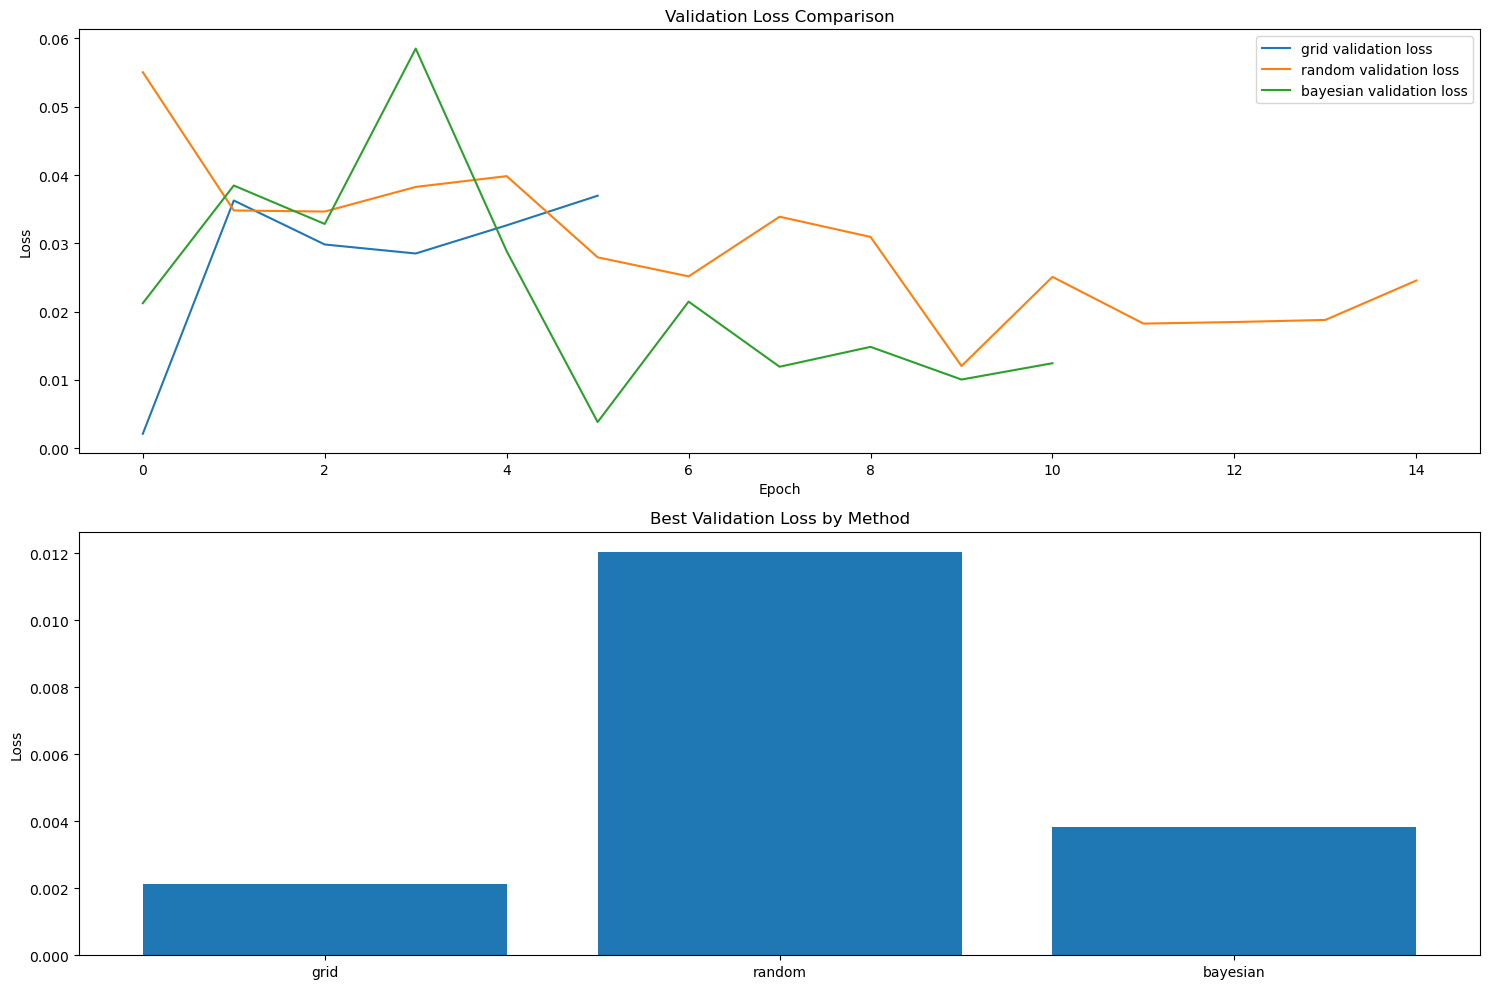

In [9]:
# Visualize results
print("\nGenerating visualizations...")
tuner.visualize_results(results)

In [11]:
# Print final summary
print("\nFinal Results Summary:")
for method, result in results.items():
    best_val_loss = min(result['history']['val_loss'])
    print(f"{method} - Best validation loss: {best_val_loss:.6f}")


Final Results Summary:
grid - Best validation loss: 0.002121
random - Best validation loss: 0.012037
bayesian - Best validation loss: 0.003831


# Best Practices for Hyperparameter Tuning

## 1. Start with a Baseline Model

- Begin with default hyperparameters
- Establish baseline performance
- Identify areas for improvement

## 2. Systematic Approach

- Change one hyperparameter at a time
- Document impact of each change
- Keep track of all experiments

## 3. Use Cross-Validation

- Ensures robust performance estimates
- Helps prevent overfitting to validation set
- Particularly important for time series data

## 4. Monitor Multiple Metrics

- Training loss
- Validation loss
- Domain-specific metrics
- Training time and resource usage

# Common Pitfalls and Solutions

## Overfitting

- **Symptom**: Low training loss, high validation loss
- **Solutions**:
  - Increase dropout rate
  - Reduce model capacity
  - Add regularization
  - Collect more training data

## Underfitting

- **Symptom**: High training and validation loss
- **Solutions**:
  - Increase model capacity
  - Decrease dropout rate
  - Train for more epochs
  - Adjust learning rate

## Unstable Training

- **Symptom**: Fluctuating loss values
- **Solutions**:
  - Reduce learning rate
  - Increase batch size
  - Add gradient clipping
  - Normalize inputs

# Conclusion

Effective hyperparameter tuning is crucial for developing high-performing LSTM models. The process requires:
- Understanding the role of each hyperparameter
- Systematic experimentation
- Careful monitoring of results
- Patience and persistence

Remember that there's often no single "best" set of hyperparameters - the optimal configuration depends on your specific problem, data, and requirements.